In [1]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io, transform
import numpy as np
from torchvision import utils, transforms, datasets
from torch.utils.data import Subset
from datetime import datetime
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

In [3]:
from dataset_functions import *

In [4]:
torch.cuda.is_available()

True

In [22]:
torch.manual_seed(42)

In [ ]:
PLOT_DATASET = False

In [6]:
CALCULATE_MEAN_STD = False
if CALCULATE_MEAN_STD:
    mean, std = calculate_mean_std_custom_dataset()
else:
    mean = torch.tensor([0.3403, 0.3121, 0.3214])
    std = torch.tensor([0.2724, 0.2608, 0.2669])

In [7]:
training_data_transform = transforms.Compose([
        ConvertPIL(),
        Rescale((32, 32)),
        RandCrop(32),
        RandHorizFlip(0.5),
        RandVertFlip(0.5),
        # RandomRotation(),
        ToTensor(),
        CustomNormalize(mean, std)
    ])

validation_data_transform = transforms.Compose([
        ConvertPIL(),
        Rescale((32, 32)),
        ToTensor(),
        CustomNormalize(mean, std)
    ])

In [8]:
train_dataset = TrafficSignsDataset(annotations_file='../../dataset/GTSRB/Train.csv', 
                                    root_dir='../../dataset/GTSRB',
                                    transform=training_data_transform)

valid_dataset = TrafficSignsDataset(annotations_file='../../dataset/GTSRB/Train.csv', 
                                    root_dir='../../dataset/GTSRB',
                                    transform=validation_data_transform)

total_count = len(train_dataset)
train_count = int(0.8 * total_count)
print(total_count)
print(train_count)
indices = np.arange(0, total_count, 1)
np.random.seed(42)
np.random.shuffle(indices)
train_idx, val_idx = indices[:train_count], indices[train_count:]

train_dataset = Subset(train_dataset, train_idx)
valid_dataset = Subset(valid_dataset, val_idx)

39209
31367


In [9]:
#print(train_dataset.dataset.transform)
#print(valid_dataset.dataset.transform)

Compose(
)
Compose(
)


In [10]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=64,
                                             shuffle=True,
                                             num_workers=4)

validation_dataset_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=64,
                                             shuffle=True,
                                             num_workers=4)

In [ ]:
if PLOT_DATASET:
    plot_gtsrb_dataset_images(train_dataset_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


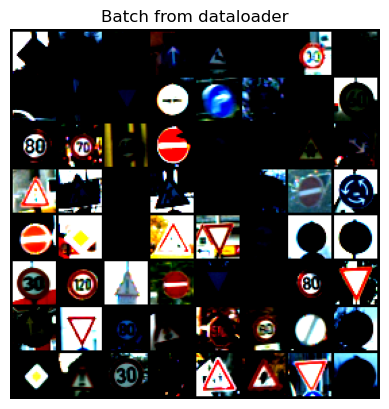

In [13]:
test_traffic_dataset = TrafficSignsDataset(annotations_file='../../dataset/GTSRB/Test.csv', 
                                           root_dir='../../dataset/GTSRB', 
                                           transform=transforms.Compose([
                                            ConvertPIL(),
                                            Rescale((32, 32)),
                                            ToTensor(),
                                            CustomNormalize(mean, std)
                                        ]))

test_dataset_loader = torch.utils.data.DataLoader(test_traffic_dataset,
                                                batch_size=64,
                                                shuffle=True,
                                                num_workers=4)

if PLOT_DATASET:
    plot_gtsrb_dataset_images(test_dataset_loader)

In [14]:
num_classes = len(train_dataset.dataset.get_classes())
print(num_classes)

from model import CustomCNN
net = CustomCNN(num_classes=num_classes)

43


In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)

CustomCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(3, 3), stride=1, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(3, 3), stride=1, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=51200, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=43, bias=True)
  )
)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [17]:
EPOCHS = 10 # Load from a config file

In [18]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_dataset_loader):
        # Every data instance is an input + label pair
        inputs = data['image']
        labels = data['label']

        inputs, labels = inputs.to(device), labels.to(device)

        # Zero your gradients for every batch
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = net(inputs)

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('batch {} loss: {}'.format(i + 1, last_loss))
            # tb_x = epoch_index * len(train_dataset_loader) + i + 1
            # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [19]:
best_vloss = 1_000_000.
epoch_number = 0
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print('EPOCH {}:'.format(epoch_number + 1))
    running_loss = 0.
    last_loss = 0.

    net.train(True)
    avg_loss = train_one_epoch(epoch)

    running_vloss = 0.0

    # Set the model in evaluation mode
    net.eval()
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for j, val_data in enumerate(validation_dataset_loader):
            inputs = val_data['image']
            labels = val_data['label']

            inputs, labels = inputs.to(device), labels.to(device)
            
            target = net(inputs)
            vloss = criterion(target, labels)
            running_vloss += vloss
    
        avg_vloss = running_vloss / (j + 1)
        print('LOSS train {} validation {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        # writer.add_scalars('Training vs. Validation Loss',
        #                 { 'Training' : avg_loss, 'Validation' : avg_vloss },
        #                 epoch_number + 1)
        # writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'customcnn_{}_{}'.format(timestamp, epoch_number)
            torch.save(net.state_dict(), '../models/'+model_path)
        
        epoch_number += 1

EPOCH 1:
batch 100 loss: 3.28354829788208
batch 200 loss: 2.96904305934906
batch 300 loss: 2.6759211373329164
batch 400 loss: 2.392209583520889
LOSS train 2.392209583520889 validation 1.6120476722717285
EPOCH 2:
batch 100 loss: 1.9575625550746918
batch 200 loss: 1.790199364423752
batch 300 loss: 1.6983876407146454
batch 400 loss: 1.5720227432250977
LOSS train 1.5720227432250977 validation 0.7542895078659058
EPOCH 3:
batch 100 loss: 1.3495169055461884
batch 200 loss: 1.2586857235431672
batch 300 loss: 1.2460846030712127
batch 400 loss: 1.17353489279747
LOSS train 1.17353489279747 validation 0.42890945076942444
EPOCH 4:
batch 100 loss: 1.0864689093828201
batch 200 loss: 1.0379485434293747
batch 300 loss: 1.0008216750621797
batch 400 loss: 0.980347290635109
LOSS train 0.980347290635109 validation 0.34270867705345154
EPOCH 5:
batch 100 loss: 0.9152053982019425
batch 200 loss: 0.8915994995832444
batch 300 loss: 0.8502560460567474
batch 400 loss: 0.9058371943235397
LOSS train 0.9058371943235

In [20]:
# net = Net()
# net.load_state_dict(torch.load(PATH))

net.eval()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, test_data in enumerate(test_dataset_loader):
        inputs = test_data['image']
        labels = test_data['label']

        inputs, labels = inputs.to(device), labels.to(device)

        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 86 %


In [ ]:
# prepare to count predictions for each class

# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # again no gradients needed
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         outputs = net(images)
#         _, predictions = torch.max(outputs, 1)
#         # collect the correct predictions for each class
#         for label, prediction in zip(labels, predictions):
#             if label == prediction:
#                 correct_pred[classes[label]] += 1
#             total_pred[classes[label]] += 1


# # print accuracy for each class
# for classname, correct_count in correct_pred.items():
#     accuracy = 100 * float(correct_count) / total_pred[classname]
#     print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [21]:
# TODO
# add more transformations
# add dropout